In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import itertools

#For local jum002 HPC setup
import sys
sys.path.append("/home/jum002/store5/repo/smrt_fork/smrt")
sys.path.append("/home/jum002/store5/repo/snowmicropyn")

# Need forked snowmicropyn from https://github.com/mjsandells/snowmicropyn
from snowmicropyn import density_ssa, profile
import akross_common_functions as AK

In [2]:
# King 2020 coefficients. SSA are from TVC and assumed to apply to Eureka / Alert
#k2020_coeffs = {'density':[312.54, 50.27, -50.26, -85.35], 'ssa':[12.05, -12.28, -1], 'equation':'ssa'}
#k2020_coeffs = {'density':[312.54, 50.27, -50.26, -85.35], 'ssa':[9.212, -14.627, -1.582], 'equation':'ssa'}

#those SSA coef require np.exp(ssa) (montpetit et al 2023)
k2020_coeffs = {'density':[312.54, 50.27, -50.26, -85.35], 'ssa':[2.37, -0.7, -0.06], 'equation':'ssa'}

### Alert and Eureka
Prepare smp dataframe with Salinity and temperature from pit

In [3]:
def smp_snowpacks(list_of_filenames, list_of_file_sites, salt_dict, temp_dict, layer_thickness=0.03):
    # Function to take in an SMP measurement file, derive density and SSA
    # And generate SMRT snowpack
    # layer_thickness governs the thickness of layers to be used in SMRT
    # default layer_thickness is 5cm    
        
    snowpacks = []
    
    # Loop over SMP files for site:
    for smp, site in zip(list_of_filenames, list_of_file_sites):
        
        # 1. Take median and process density / SSA
        #smp_median = density_ssa.median_profile([smp])
        try:
            smp_profile = profile.Profile(smp)
            surface = smp_profile.detect_surface()
            ground = smp_profile.detect_ground()
            c2020_m = density_ssa.calc(smp_profile.samples_within_snowpack(), coeff_model=k2020_coeffs, window=5, overlap=50)
            total_depth_in_m = c2020_m.distance.iloc[-1] * 1e-3

            # 2. Group density / SSA into layers. Take median
            current_thickness = c2020_m.distance.diff().iloc[-1] * 1e-3 # Convert to m
            number_in_group = int(layer_thickness / current_thickness)
            df = c2020_m.rolling(number_in_group).median()
            df = df.iloc[number_in_group::number_in_group, :]

            # 3. Calculate number of layers needed
            nlayers = len(df)

            # 4. Assign layer thickness from top, with any remaining depth allocated to bottom layer
            thickness_array = nlayers * [layer_thickness]
            # Add in remaining profile to lowest layer
            extra_thickness = total_depth_in_m - sum(thickness_array)
            thickness_array[-1] += extra_thickness
            df['thick'] = thickness_array
            
            # 5. Extract density
            df['density'] = df.density

            # 6. Derive exp corr length
            df['ssa'] = np.exp(df.ssa)


            #get height from salt and temp interpolation
            height = np.cumsum(thickness_array[::-1])

            #get poly
            poly_ws = 0.7*np.ones(int(len(height)/2))
            poly_dh = 1.3*np.ones(int(len(height)/2)+ int(len(height)%2))
            df['polydispersity'] = np.concatenate([poly_ws, poly_dh])

            #set salinity of snow layer
            salt_pit = salt_dict[site]
            df['salinity'] = np.interp(height, salt_pit.height[::-1].values/100, salt_pit.param[::-1])[::-1]

            #settemp array
            temp_pit = temp_dict[site]
            temp_pit.param[temp_pit.param <-22] = -22
            df['temperature'] = np.interp(height, temp_pit.height[::-1].values/100, temp_pit.param[::-1])[::-1] + 273

            snowpacks.append(df)

        except:
            print ('make snowpack failed for', smp)
            pass
            
    return snowpacks

In [4]:
salt_dict = pd.read_pickle('smrt_in-out/alert_eureka_salt_dict')
temp_dict = pd.read_pickle('smrt_in-out/alert_eureka_temp_dict')

In [5]:
# Get list of sites (upper folders)
# Data from https://doi.org/10.5281/zenodo.4068349

#data_dir = '../DATA/SMP/Sites'
#data_dir = 'C:/Users/melochej/Documents/code-workshop/AKROSS/DATA/SMP/Sites'
data_dir = '/home/jum002/store5/data/AKROSS_data/Alert-Eureka/SMP/Sites'

list_of_sites = os.listdir(path=data_dir)
# Split Eureka and Alert sites
eureka_sites = [s for s in list_of_sites if 'Eureka' in s]
alert_sites = [s for s in list_of_sites if 'Alert' in s]

E_smp_files, E_smp_sites = [], []
for s in eureka_sites:
    E_smp_files.append(AK.find_site_smp_files(s, data_dir = data_dir)[0])
    E_smp_sites.append(AK.find_site_smp_files(s, data_dir = data_dir)[1])
# Flatten list of lists
eureka_smp_files = list(itertools.chain(*E_smp_files))
eureka_smp_sites = list(itertools.chain(*E_smp_sites))


A_smp_files, A_smp_sites = [], []
for s in alert_sites:
    A_smp_files.append(AK.find_site_smp_files(s, data_dir = data_dir)[0])
    A_smp_sites.append(AK.find_site_smp_files(s, data_dir = data_dir)[1])
# Flatten list of lists
alert_smp_files = list(itertools.chain(*A_smp_files))
alert_smp_sites = list(itertools.chain(*A_smp_sites))


list_smp_E16 = smp_snowpacks(eureka_smp_files, eureka_smp_sites, salt_dict, temp_dict, layer_thickness=0.03)
list_smp_A = smp_snowpacks(alert_smp_files, alert_smp_sites, salt_dict, temp_dict, layer_thickness=0.03)

make snowpack failed for /home/jum002/store5/data/AKROSS_data/Alert-Eureka/SMP/Sites/Eureka_3_FYI/S34M0398.pnt
make snowpack failed for /home/jum002/store5/data/AKROSS_data/Alert-Eureka/SMP/Sites/Eureka_3_FYI/S34M0432.pnt
make snowpack failed for /home/jum002/store5/data/AKROSS_data/Alert-Eureka/SMP/Sites/Eureka_3_FYI/S34M0401.pnt
make snowpack failed for /home/jum002/store5/data/AKROSS_data/Alert-Eureka/SMP/Sites/Eureka_3_FYI/S34M0392.pnt
make snowpack failed for /home/jum002/store5/data/AKROSS_data/Alert-Eureka/SMP/Sites/Eureka_3_FYI/S34M0399.pnt
make snowpack failed for /home/jum002/store5/data/AKROSS_data/Alert-Eureka/SMP/Sites/Eureka_2_FYI/S34M0330.pnt
make snowpack failed for /home/jum002/store5/data/AKROSS_data/Alert-Eureka/SMP/Sites/Alert_7_MYI/S34M1884.pnt
make snowpack failed for /home/jum002/store5/data/AKROSS_data/Alert-Eureka/SMP/Sites/Alert_7_MYI/S34M1886.pnt
make snowpack failed for /home/jum002/store5/data/AKROSS_data/Alert-Eureka/SMP/Sites/Alert_7_MYI/S34M1885.pnt
make

In [6]:
with open('smrt_in-out/smp_profile_E16_3cm', 'wb') as pickle_file:
    pickle.dump(list_smp_E16, pickle_file)

with open('smrt_in-out/smp_profile_A_3cm', 'wb') as pickle_file:
    pickle.dump(list_smp_A, pickle_file)

### Cambay
Prepare smp dataframe with Salinity and temperature from pit

In [7]:
data_dir = '/home/jum002/store5/data/AKROSS_data/CB22/SMP/Sites/'

def build_smp_input(site, layer_thickness, snow_info):
    list_smp = sorted(os.listdir(data_dir + site))
    list_profile = []

    #import snow pit info fro temp and salinity
    temperature_pit = snow_info[site].temperature
    salinity_pit = snow_info[site].salinity
    htop_pit = snow_info[site].htop #convert to m
    for smp in list_smp: 
        if smp.lower().endswith(".pnt"):
            try:
                test_case = profile.Profile(data_dir + site +'/'+ smp)
                surface = test_case.detect_surface()
                ground = test_case.detect_ground()
                df = test_case.samples_within_snowpack()
                df_param = density_ssa.calc(df, coeff_model=k2020_coeffs, window=5, overlap=50)
                #get rolling median for define thickness for smrt
                current_thickness = df_param.distance.diff().iloc[-1] * 1e-3 # Convert to m
                number_in_group = int(layer_thickness / current_thickness)
                df_final = df_param.rolling(number_in_group).median()
                smp_smrt = df_final.iloc[number_in_group::number_in_group, :]
                smp_smrt['ssa'] = np.exp(smp_smrt.ssa)
                #get temperature and salinity from pit info
                htop_smp = (smp_smrt.distance.values[-1] - smp_smrt.distance) * 1e-3  
                thick = [layer_thickness for i in range(0,len(htop_smp))]
                # indice [::-1] because x needs to be monotonically increasing
                temperature = np.interp(htop_smp[::-1], htop_pit[::-1], temperature_pit)
                salinity = np.interp(htop_smp[::-1], htop_pit[::-1].iloc[:-1], salinity_pit.iloc[:-1])
                salinity[-1] = salinity_pit.iloc[-1]
                #add to dataframe
                smp_smrt.loc[:,'temperature'] = temperature
                smp_smrt.loc[:,'salinity'] = salinity
                smp_smrt.loc[:,'thick'] = thick

                list_profile.append(smp_smrt)
            except Exception as error:
                #print(error)
                print(f'error with {smp}, less than layer thickness define...')


    return list_profile


import pickle
#import snowpit info from pickle file
with open('smrt_in-out/snowpitCB2022_SMRT_input.txt', 'rb') as pickle_file:
    snow_info = pickle.load(pickle_file)

#3cm
ds_AK1 = build_smp_input('AK1', 0.03, snow_info)
ds_AK2 = build_smp_input('AK2', 0.03, snow_info)
ds_AK3 = build_smp_input('AK3', 0.03, snow_info)
ds_AK4 = build_smp_input('AK4', 0.03, snow_info)

list_smp_CB = ds_AK1 + ds_AK2 + ds_AK3 + ds_AK4

with open('smrt_in-out/smp_profile_CB_3cm', 'wb') as pickle_file:
    pickle.dump(list_smp_CB, pickle_file)

error with S40M1556.pnt, less than layer thickness define...
error with S40M1562.pnt, less than layer thickness define...
error with S40M1563.pnt, less than layer thickness define...
error with S40M1612.pnt, less than layer thickness define...


Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None


error with S40M1634.pnt, less than layer thickness define...
error with S40M1636.pnt, less than layer thickness define...
error with S40M1637.pnt, less than layer thickness define...
error with S40M1638.pnt, less than layer thickness define...
error with S40M1640.pnt, less than layer thickness define...
error with S40M1642.pnt, less than layer thickness define...
error with S40M1645.pnt, less than layer thickness define...
error with S40M1648.pnt, less than layer thickness define...


In [8]:
# #other layer thickness to check with CT

# #5mm
# ds_AK1 = build_smp_input('AK1', 0.005, snow_info)
# ds_AK2 = build_smp_input('AK2', 0.005, snow_info)
# ds_AK3 = build_smp_input('AK3', 0.005, snow_info)
# ds_AK4 = build_smp_input('AK4', 0.005, snow_info)

# list_smp_CB = ds_AK1 + ds_AK2 + ds_AK3 + ds_AK4

# with open('smrt_in-out/smp_profile_CB_5mm', 'wb') as pickle_file:
#     pickle.dump(list_smp_CB, pickle_file)

# #1cm
# ds_AK1 = build_smp_input('AK1', 0.01, snow_info)
# ds_AK2 = build_smp_input('AK2', 0.01, snow_info)
# ds_AK3 = build_smp_input('AK3', 0.01, snow_info)
# ds_AK4 = build_smp_input('AK4', 0.01, snow_info)

# list_smp_CB = ds_AK1 + ds_AK2 + ds_AK3 + ds_AK4

# with open('smrt_in-out/smp_profile_CB_1cm', 'wb') as pickle_file:
#     pickle.dump(list_smp_CB, pickle_file)

# #2cm
# ds_AK1 = build_smp_input('AK1', 0.02, snow_info)
# ds_AK2 = build_smp_input('AK2', 0.02, snow_info)
# ds_AK3 = build_smp_input('AK3', 0.02, snow_info)
# ds_AK4 = build_smp_input('AK4', 0.02, snow_info)

# list_smp_CB = ds_AK1 + ds_AK2 + ds_AK3 + ds_AK4

# with open('smrt_in-out/smp_profile_CB_2cm', 'wb') as pickle_file:
#     pickle.dump(list_smp_CB, pickle_file)

# #5cm
# ds_AK1 = build_smp_input('AK1', 0.05, snow_info)
# ds_AK2 = build_smp_input('AK2', 0.05, snow_info)
# ds_AK3 = build_smp_input('AK3', 0.05, snow_info)
# ds_AK4 = build_smp_input('AK4', 0.05, snow_info)

# list_smp_CB = ds_AK1 + ds_AK2 + ds_AK3 + ds_AK4

# with open('smrt_in-out/smp_profile_CB_5cm', 'wb') as pickle_file:
#     pickle.dump(list_smp_CB, pickle_file)

#### Eureka 22

In [9]:
data_pit_folder = "/home/jum002/store5/data/AKROSS_data/Eureka22/PIT/Daily_pit_files"
smp_daily = "/home/jum002/store5/data/AKROSS_data/Eureka22/SMP/2022-04_AllDailySMPNotes_Combined.xlsx"
dir_smp = "/home/jum002/store5/data/AKROSS_data/Eureka22/SMP/RAW_pnt_files"

In [10]:

#build dictionnary of temperature from pit
dict_site = {}
for file in os.listdir(data_pit_folder):
    df = pd.read_excel(os.path.join(data_pit_folder, file), sheet_name = "PIT", skiprows = 7)
    df_salt = pd.read_excel(os.path.join(data_pit_folder, file), sheet_name = "Salinity")

    site = file[11:-21]
    temperature = df['Temp.'][1:].dropna().values
    height = df['Height above ground'][1:].dropna().values
    salinity = df_salt['PPT'].dropna().values
    height_salinity = df_salt['Height'].dropna().values

    #temperature limit à -22 for saline snow
    # index = np.where(temperature <=-22)
    # temperature[index] = -22
            

    dict_temp = {'height' : height, 'temperature' : temperature + 273, 'height_salt' : height_salinity, 'salinity' : salinity}
    dict_site[site] = dict_temp

#get refrence for smp file to corresponding pit
df_smp_note = pd.read_excel(smp_daily)
dict_smp = {}
for index, row in df_smp_note.iterrows():
    dict_smp[str(row['File'])] = row['Site Name']

In [11]:
# salt_basal = [item[1]['salinity'][-3:].mean() for item in dict_site.items()]
# print(f'mean salt fro basal layer :{np.mean(salt_basal)} ± {np.std(salt_basal)}')

In [12]:
list_smp_name = sorted(os.listdir(dir_smp))

layer_thickness = 0.03

list_smp_E22, list_smp_nopit = [], []
for smp in list_smp_name:
    ssa, density, depth = [], [], []
    if smp.lower().endswith(".pnt"):
        test_case = profile.Profile(os.path.join(dir_smp, smp))
        surface = test_case.detect_surface()
        ground = test_case.detect_ground()
        df = test_case.samples_within_snowpack()
        df_param = density_ssa.calc(df, coeff_model=k2020_coeffs, window=5, overlap=50)

        #total depth
        total_depth_in_m = df_param.distance.iloc[-1] * 1e-3

        #get rolling median for define thickness for smrt
        current_thickness = df_param.distance.diff().iloc[-1] * 1e-3 # Convert to m
        number_in_group = int(layer_thickness / current_thickness)
        df_final = df_param.rolling(number_in_group).median()
        smp_smrt = df_final.iloc[number_in_group::number_in_group, :]


        try:
            #get temperature from pit
            site_temp = dict_smp[smp[4:-4]]
            temperature_pit = np.array(dict_site[site_temp]['temperature'], dtype = float)
            htop_pit = np.array(dict_site[site_temp]['height'], dtype = float) * 1e-2
            salinity_pit = np.array(dict_site[site_temp]['salinity'], dtype = float)[:-1]
            htop_salt = np.array(dict_site[site_temp]['height_salt'], dtype = float)[:-1]* 1e-2

            #get temperature and salinity from pit info
            depth = smp_smrt.distance.values * 1e-3
            #4. Assign layer thickness from top, with any remaining depth allocated to bottom layer
            thick = [layer_thickness for i in range(0,len(depth))]
            # Add in remaining profile to lowest layer
            extra_thickness = total_depth_in_m - sum(thick)
            thick[-1] += extra_thickness

            htop_smp = np.cumsum(np.array(thick)[::-1])[::-1]

            # indice [::-1] because x needs to be monotonically increasing
            temperature = np.interp(htop_smp[::-1], htop_pit[::-1], temperature_pit[::-1])[::-1]
            salinity = np.interp(htop_smp[::-1], htop_salt[::-1], salinity_pit[::-1])[::-1]

            list_smp_E22.append(pd.DataFrame({'ssa' : np.exp(smp_smrt.ssa.values), 'density' : smp_smrt.density.values, 'htop' : htop_smp,
                                    'thick' : thick, 'temperature' : temperature, 'salinity' : salinity, 'pit' : site_temp}))
        except:
            #print(e)
            #print(f'no pit found for file : {site_temp}')

            #get temperature and salinity from pit info
            htop_smp = (smp_smrt.distance.values[-1] - smp_smrt.distance.values) * 1e-3  
            thick = [layer_thickness for i in range(0,len(htop_smp))]

            # indice [::-1] because x needs to be monotonically increasing
            # temperature = np.interp(htop_smp[::-1], htop_pit[::-1], temperature_pit)
            # list_smp_nopit.append({'ssa' : smp_smrt.ssa.values, 'density' : smp_smrt.density.values, 'depth' : smp_smrt.distance.values,
            #                         'thick' : thick, 'temperature' : temperature, 'pit' : site_temp})
            list_smp_nopit.append({'ssa' : np.exp(smp_smrt.ssa.values), 'density' : smp_smrt.density.values, 'htop' : htop_smp,
                                    'thick' : thick, 'pit' : site_temp})

Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
Latitude value -99999.0 invalid, replacing by None
Longitude value -99999

In [13]:
with open('smrt_in-out/smp_profile_E22_3cm', 'wb') as pickle_file:
    pickle.dump(list_smp_E22, pickle_file)

###  Box plot of snow properties for each site
fig in methodology

In [14]:
def get_all_param(list_smp):
    site_ssa = [item for sublist in [list(pit.ssa.values) for pit in list_smp] for item in sublist]
    site_density = [item for sublist in [list(pit.density.values) for pit in list_smp] for item in sublist]
    site_depth = np.array([np.sum(pit.thick) for pit in list_smp]) * 1e3

    return site_ssa, site_density, site_depth

E22_ssa, E22_density, E22_depth = get_all_param(list_smp_E22)
CB_ssa, CB_density, CB_depth = get_all_param(list_smp_CB)
A_ssa, A_density, A_depth = get_all_param(list_smp_A)
E16_ssa, E16_density, E16_depth = get_all_param(list_smp_E16)

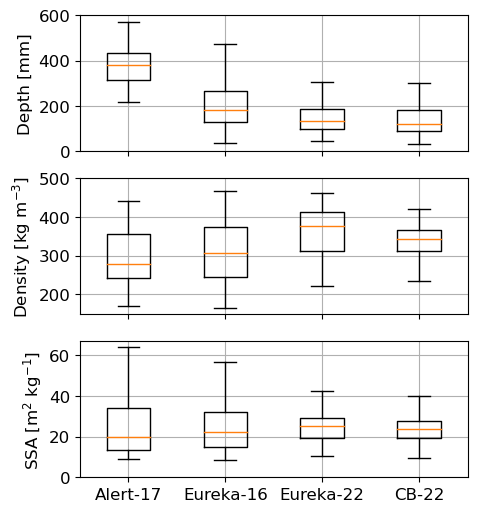

In [15]:
sites = ['Alert-17', 'Eureka-16', 'Eureka-22', 'CB-22']

# Make box plots
plt.rcParams.update({'font.size': 12})
plt.close()
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(5,6))
ax1.boxplot([A_depth, E16_depth, E22_depth, CB_depth], showfliers=False)
ax2.boxplot([A_density, E16_density, E22_density, CB_density], showfliers=False)
ax3.boxplot([A_ssa, E16_ssa, E22_ssa, CB_ssa], showfliers=False)

ax1.set_ylabel('Depth [mm]')
ax2.set_ylabel('Density [kg m$^{-3}$]')
ax3.set_ylabel('SSA [m$^2$ kg$^{-1}$]')

ax1.set_yticks([0,200,400,600])
ax2.set_yticks([200,300,400,500])
ax3.set_yticks([0,20,40,60])

ax3.set_xticklabels([])
ax3.set_xticks(range(1,5))
ax3.set_xticklabels(sites, rotation=0);

ax1.grid()
ax2.grid()
ax3.grid()


#jul_path = 'C:/Users/melochej/OneDrive - EC-EC/Documents/post-doc/AKROSS/article/fig_output'
#plt.savefig(jul_path +'SMP_data.png', format='png', dpi=300, bbox_inches='tight')